In [83]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import shutil

In [2]:
train_EOSINOPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/TRAIN/EOSINOPHIL")

train_LYMPHOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/TRAIN/LYMPHOCYTE")

train_MONOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/TRAIN/MONOCYTE")

train_NEUTROPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/TRAIN/NEUTROPHIL")

In [3]:
test_EOSINOPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/TEST/EOSINOPHIL")

test_LYMPHOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/TEST/LYMPHOCYTE")

test_MONOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/TEST/MONOCYTE")

test_NEUTROPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/TEST/NEUTROPHIL")

In [72]:
val_EOSINOPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/VALIDATION/EOSINOPHIL")

val_LYMPHOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/VALIDATION/LYMPHOCYTE")

val_MONOCYTE = os.path.join (r"/kaggle/input/wbcdataset/images/VALIDATION/MONOCYTE")

val_NEUTROPHIL = os.path.join (r"/kaggle/input/wbcdataset/images/VALIDATION/NEUTROPHIL")

**Some example images of each WBC type**

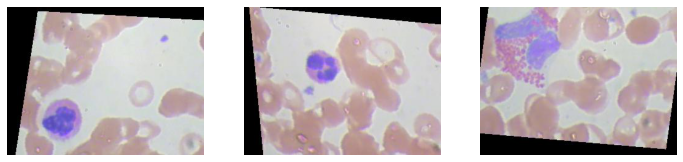

In [4]:
eosinophil_img = [os.path.join(train_EOSINOPHIL, file)
              for file in os.listdir(train_EOSINOPHIL)[:3]]
plt.figure(figsize=(12, 3))
for i, img_path in enumerate(eosinophil_img):
    sp = plt.subplot(1, 3, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

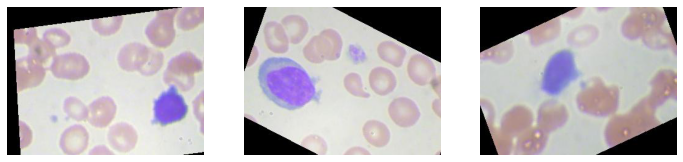

In [5]:
lymphocyte_img = [os.path.join(train_LYMPHOCYTE, file)
              for file in os.listdir(train_LYMPHOCYTE)[:3]]
plt.figure(figsize=(12, 3))
for i, img_path in enumerate(lymphocyte_img):
    sp = plt.subplot(1, 3, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

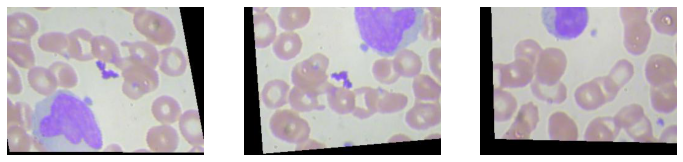

In [6]:
monocyte_img = [os.path.join(train_MONOCYTE, file)
              for file in os.listdir(train_MONOCYTE)[:3]]
plt.figure(figsize=(12, 3))
for i, img_path in enumerate(monocyte_img):
    sp = plt.subplot(1, 3, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

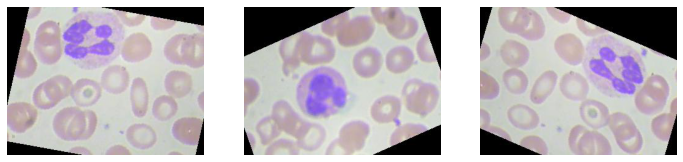

In [7]:
neutrophil_img = [os.path.join(train_NEUTROPHIL, file)
              for file in os.listdir(train_NEUTROPHIL)[:3]]
plt.figure(figsize=(12, 3))
for i, img_path in enumerate(neutrophil_img):
    sp = plt.subplot(1, 3, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

***

**Defining and loading the train and test data generators**

In [8]:
datagen = ImageDataGenerator()

In [9]:
batch_size = 64
img_height = 128
img_width = 128

In [71]:
train_generator = datagen.flow_from_directory(
    directory=r"/kaggle/input/wbcdataset/images/TRAIN", 
    target_size=(img_height, img_width), 
    batch_size = batch_size,
    class_mode='categorical',
    seed = 42
)

test_generator = datagen.flow_from_directory(
    directory=r"/kaggle/input/wbcdataset/images/TEST", 
    target_size=(img_height, img_width), 
    batch_size = batch_size,
    class_mode='categorical',
    seed = 42
)

Found 7967 images belonging to 4 classes.
Found 1990 images belonging to 4 classes.


In [11]:
train_steps = math.ceil(7967/batch_size)
test_steps = math.ceil(1990/batch_size)

In [101]:
label_map = (train_generator.class_indices)

# get wbc type name from encoded value
def getType(id):
    return list(label_map.keys())[list(label_map.values()).index(id)]

# predict wbc type of new images
def predictNewImages(model, val_wbc):
    val_df = pd.DataFrame(columns=['Image No.', 'Predicted WBC Type'])
    wbc_img = [os.path.join(val_wbc, file) 
                      for file in os.listdir(val_wbc)[:]]
    for i, img_path in enumerate(wbc_img):
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_batch)
        val_df.loc[len(val_df.index)] = [(i+1), getType(np.argmax(prediction))]
    return val_df

***

# **Inception CNN**

In [12]:
input_image = layers.Input(shape=(img_height,img_width,3))

layer_11 = layers.Conv2D(filters = 32, kernel_size = 1, activation = 'relu', input_shape = (img_height, img_width, 3))(input_image)
layer_11 = layers.MaxPooling2D(pool_size = 2)(layer_11)
layer_12 = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(layer_11)
layer_12 = layers.MaxPooling2D(pool_size = 2)(layer_12)
layer_1 = layers.Dropout(0.2)(layer_12)

layer_21 = layers.Conv2D(filters = 32, kernel_size = 1, activation = 'relu', input_shape = (img_height, img_width, 3))(input_image)
layer_21 = layers.MaxPooling2D(pool_size = 2)(layer_21)
layer_22 = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(layer_21)
layer_22 = layers.MaxPooling2D(pool_size = 2)(layer_22)
layer_2 = layers.Dropout(0.2)(layer_22)

layer_31 = layers.Conv2D(filters = 32, kernel_size = 1, activation = 'relu', input_shape = (img_height, img_width, 3))(input_image)
layer_31 = layers.MaxPooling2D(pool_size = 2)(layer_31)
layer_32 = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(layer_31)
layer_32 = layers.MaxPooling2D(pool_size = 2)(layer_32)
layer_3 = layers.Dropout(0.2)(layer_32)

mid_1 = layers.concatenate([layer_1, layer_2, layer_3])

global_avg = layers.GlobalAveragePooling2D()(mid_1)

dense_1 = layers.Dense(1024, activation='relu')(global_avg)

dense_2 = layers.Dense(64, activation='relu')(dense_1)

output = layers.Dense(4, activation='softmax')(dense_2)

inception_model = Model([input_image],output)
inception_model.summary()

2022-12-04 23:52:49.204776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:52:49.303834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:52:49.304593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 32) 128         input_1[0][0]                    
______________________________________________________________________________________________

2022-12-04 23:52:49.306299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:52:49.306555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:52:49.307271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:52:49.307950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

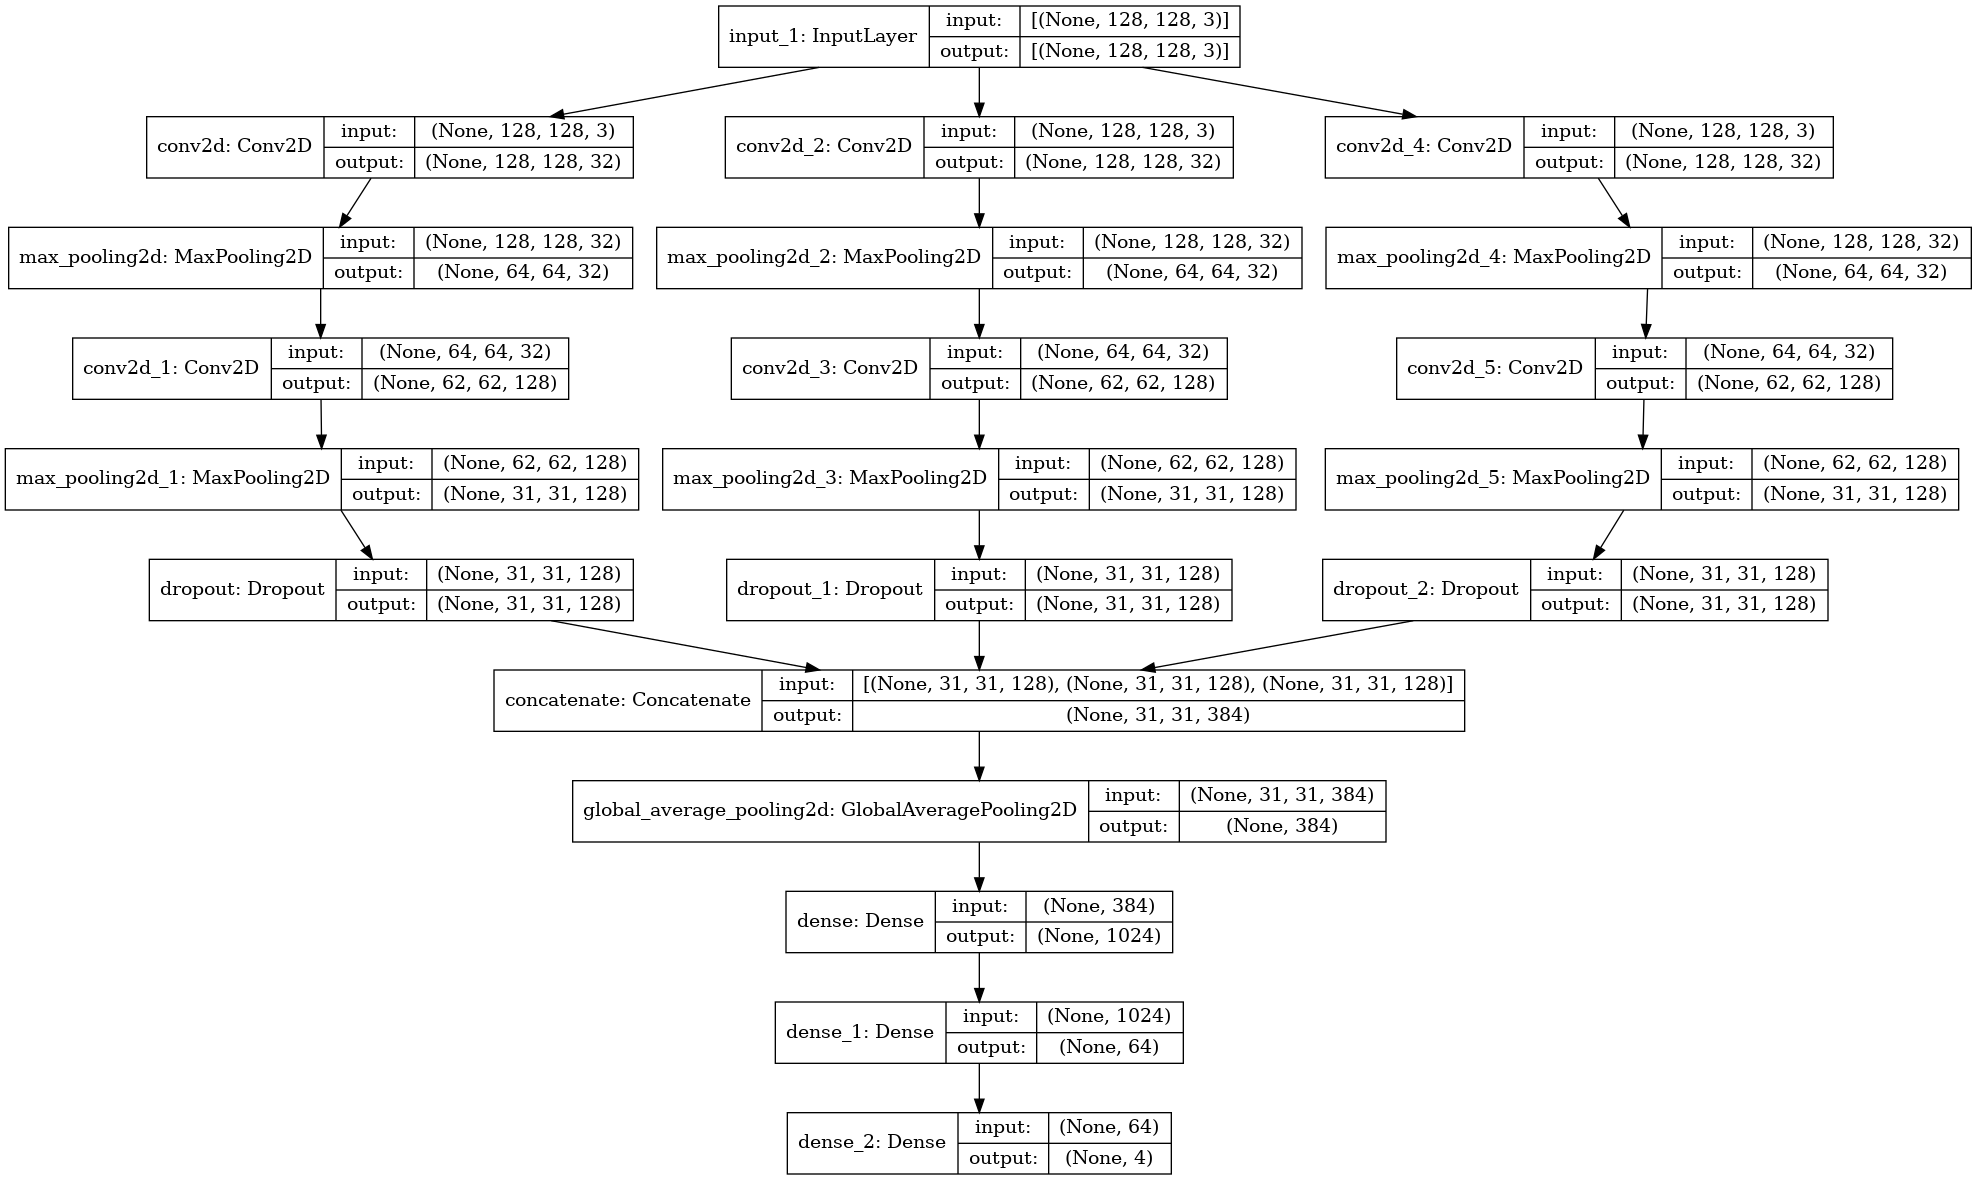

In [41]:
plot_model(inception_model, to_file='inception_model.png', show_shapes=True, show_layer_names=True)

In [14]:
inception_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
history_inception = inception_model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 50,
    verbose = 1, 
    validation_data = test_generator,
    validation_steps = test_steps
)

2022-12-04 23:53:21.352064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-04 23:53:23.341530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 62s 436ms/step - loss: 4.4726 - accuracy: 0.2827 - val_loss: 1.5073 - val_accuracy: 0.3322
Epoch 2/50
125/125 [==============================] - 21s 168ms/step - loss: 1.2337 - accuracy: 0.4343 - val_loss: 1.1283 - val_accuracy: 0.4930
Epoch 3/50
125/125 [==============================] - 24s 194ms/step - loss: 1.1090 - accuracy: 0.5120 - val_loss: 1.0082 - val_accuracy: 0.6030
Epoch 4/50
125/125 [==============================] - 20s 163ms/step - loss: 0.9561 - accuracy: 0.6101 - val_loss: 0.9084 - val_accuracy: 0.6261
Epoch 5/50
125/125 [==============================] - 21s 170ms/step - loss: 0.8587 - accuracy: 0.6502 - val_loss: 0.7935 - val_accuracy: 0.6894
Epoch 6/50
125/125 [==============================] - 21s 164ms/step - loss: 0.7587 - accuracy: 0.6946 - val_loss: 0.7160 - val_accuracy: 0.7050
Epoch 7/50
125/125 [==============================] - 21s 170ms/step - loss: 0.6930 - accuracy: 0.7267 - val_loss: 0.6397 - val_accuracy: 0.7

**Plotting the model accuracy**

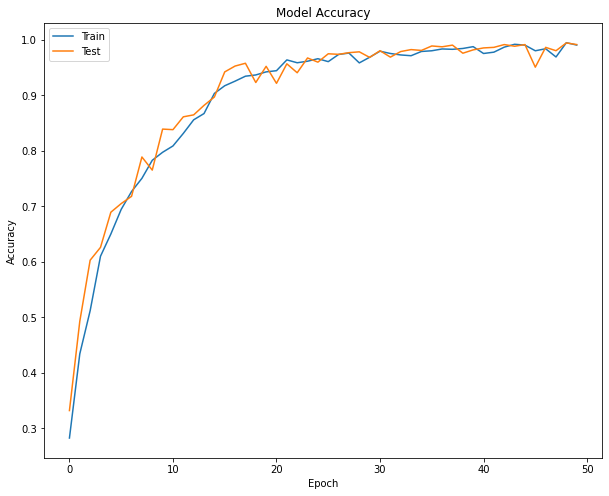

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Plotting the model loss**

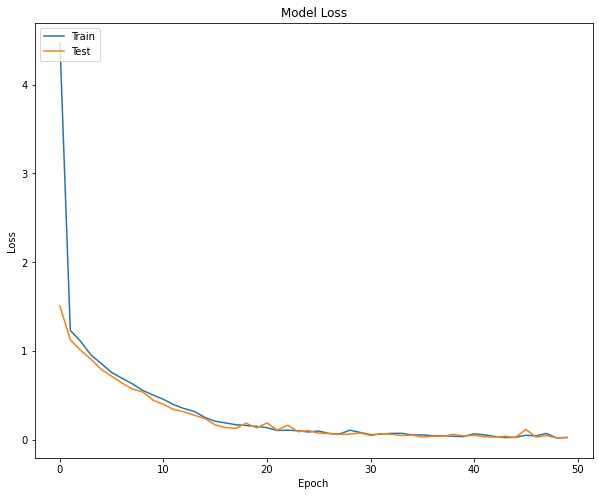

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Saving model and training history**

In [22]:
inception_model.save('Inception_Model')

In [24]:
shutil.make_archive('inception_model', 'zip', '/kaggle/working/Inception_Model')

'/kaggle/working/inception_model.zip'

In [28]:
hist_inception_df = pd.DataFrame(history_inception.history) 
with open('history_inception.csv', mode='w') as f:
    hist_inception_df.to_csv(f)

**Prediction on new images**

*Prediction on EOSINOPHIL Images*

In [102]:
eosinophil_val_df_inc = predictNewImages(inception_model, val_EOSINOPHIL)    
display(eosinophil_val_df_inc)

,Image No.,Predicted WBC Type
0,1,EOSINOPHIL
1,2,EOSINOPHIL
2,3,EOSINOPHIL
3,4,EOSINOPHIL


*Prediction on LYMPHOCYTE Images*

In [103]:
lymphocyte_val_df_inc = predictNewImages(inception_model, val_LYMPHOCYTE)
display(lymphocyte_val_df_inc)

,Image No.,Predicted WBC Type
0,1,LYMPHOCYTE
1,2,LYMPHOCYTE
2,3,LYMPHOCYTE
3,4,LYMPHOCYTE


*Prediction on MONOCYTE Images*

In [104]:
monocyte_val_df_inc = predictNewImages(inception_model, val_MONOCYTE)
display(monocyte_val_df_inc)

,Image No.,Predicted WBC Type
0,1,MONOCYTE
1,2,MONOCYTE
2,3,NEUTROPHIL
3,4,NEUTROPHIL


*Prediction on NEUTROPHIL Images*

In [105]:
neutrophil_val_df_inc = predictNewImages(inception_model, val_NEUTROPHIL)
display(neutrophil_val_df_inc)

,Image No.,Predicted WBC Type
0,1,NEUTROPHIL
1,2,NEUTROPHIL
2,3,NEUTROPHIL
3,4,NEUTROPHIL


***

# **Custom CNN**

In [29]:
cnn_model = keras.models.Sequential([
    
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size = 2),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size = 2),
    
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size = 2),
    
    layers.Dropout(0.2),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 128)       0

In [45]:
plot_model(cnn_model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

In [31]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [32]:
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 50,
    verbose = 1, 
    validation_data = test_generator,
    validation_steps = test_steps
)

Epoch 1/50
125/125 [==============================] - 21s 159ms/step - loss: 2.0296 - accuracy: 0.2637 - val_loss: 1.3916 - val_accuracy: 0.2508
Epoch 2/50
125/125 [==============================] - 20s 159ms/step - loss: 1.3274 - accuracy: 0.3379 - val_loss: 1.2804 - val_accuracy: 0.3578
Epoch 3/50
125/125 [==============================] - 20s 156ms/step - loss: 1.0989 - accuracy: 0.4943 - val_loss: 1.0209 - val_accuracy: 0.5312
Epoch 4/50
125/125 [==============================] - 19s 155ms/step - loss: 0.9234 - accuracy: 0.5913 - val_loss: 0.8656 - val_accuracy: 0.6251
Epoch 5/50
125/125 [==============================] - 21s 167ms/step - loss: 0.7134 - accuracy: 0.6908 - val_loss: 0.6001 - val_accuracy: 0.7302
Epoch 6/50
125/125 [==============================] - 20s 157ms/step - loss: 0.6018 - accuracy: 0.7436 - val_loss: 0.5175 - val_accuracy: 0.7819
Epoch 7/50
125/125 [==============================] - 20s 158ms/step - loss: 0.5006 - accuracy: 0.7850 - val_loss: 0.5430 - val_ac

**Plotting the model accuracy**

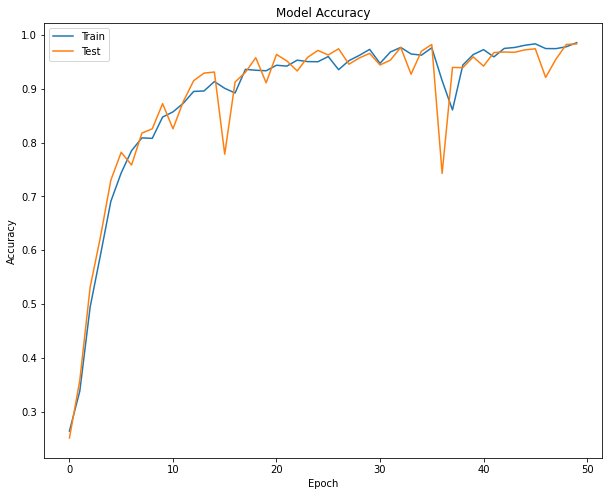

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Plotting the model loss**

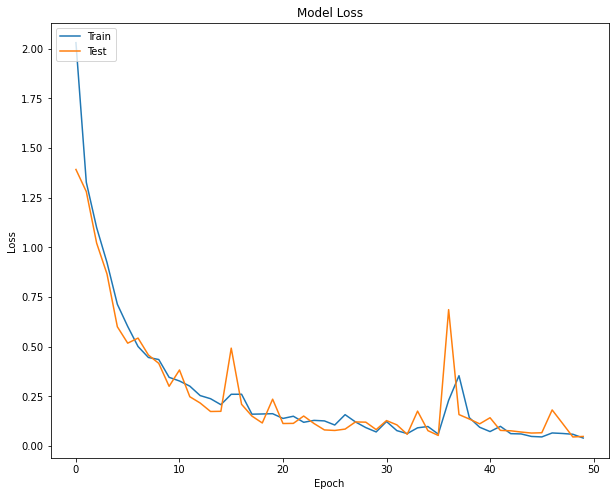

In [34]:
plt.figure(figsize=(10, 8))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Saving model and training history**

In [42]:
cnn_model.save('CNN_Model')

In [43]:
shutil.make_archive('cnn_model', 'zip', '/kaggle/working/CNN_Model')

'/kaggle/working/cnn_model.zip'

In [44]:
hist_cnn_df = pd.DataFrame(history_cnn.history) 
with open('history_cnn.csv', mode='w') as f:
    hist_inception_df.to_csv(f)

**Prediction on new images**

*Prediction on EOSINOPHIL Images*

In [106]:
eosinophil_val_df_cnn = predictNewImages(cnn_model, val_EOSINOPHIL)    
display(eosinophil_val_df_cnn)

,Image No.,Predicted WBC Type
0,1,EOSINOPHIL
1,2,EOSINOPHIL
2,3,EOSINOPHIL
3,4,EOSINOPHIL


*Prediction on LYMPHOCYTE Images*

In [107]:
lymphocyte_val_df_cnn = predictNewImages(cnn_model, val_LYMPHOCYTE)
display(lymphocyte_val_df_cnn)

,Image No.,Predicted WBC Type
0,1,LYMPHOCYTE
1,2,LYMPHOCYTE
2,3,LYMPHOCYTE
3,4,LYMPHOCYTE


*Prediction on MONOCYTE Images*

In [108]:
monocyte_val_df_cnn = predictNewImages(cnn_model, val_MONOCYTE)
display(monocyte_val_df_cnn)

,Image No.,Predicted WBC Type
0,1,MONOCYTE
1,2,MONOCYTE
2,3,NEUTROPHIL
3,4,MONOCYTE


*Prediction on NEUTROPHIL Images*

In [109]:
neutrophil_val_df_cnn = predictNewImages(cnn_model, val_NEUTROPHIL)
display(neutrophil_val_df_cnn)

,Image No.,Predicted WBC Type
0,1,NEUTROPHIL
1,2,NEUTROPHIL
2,3,NEUTROPHIL
3,4,NEUTROPHIL


***

# **ResNet**

In [116]:
base_resnet_model = ResNet50(include_top=False, weights='imagenet')
for layer in base_resnet_model.layers[:140]:
    layer.trainable = False

In [117]:
resnet_model = keras.Sequential()

resnet_model.add(layers.Input(shape = (img_height, img_width, 3)))
resnet_model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
resnet_model.add(base_resnet_model)

resnet_model.add(layers.GlobalAveragePooling2D())

resnet_model.add(layers.Dense(512, activation='relu')),
resnet_model.add(layers.Dense(64, activation='relu')),
resnet_model.add(layers.Dense(4, activation='softmax'))

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 24,669,892
Trainable params: 16,060,228
Non-trainable params: 8,609,664
__________________________________

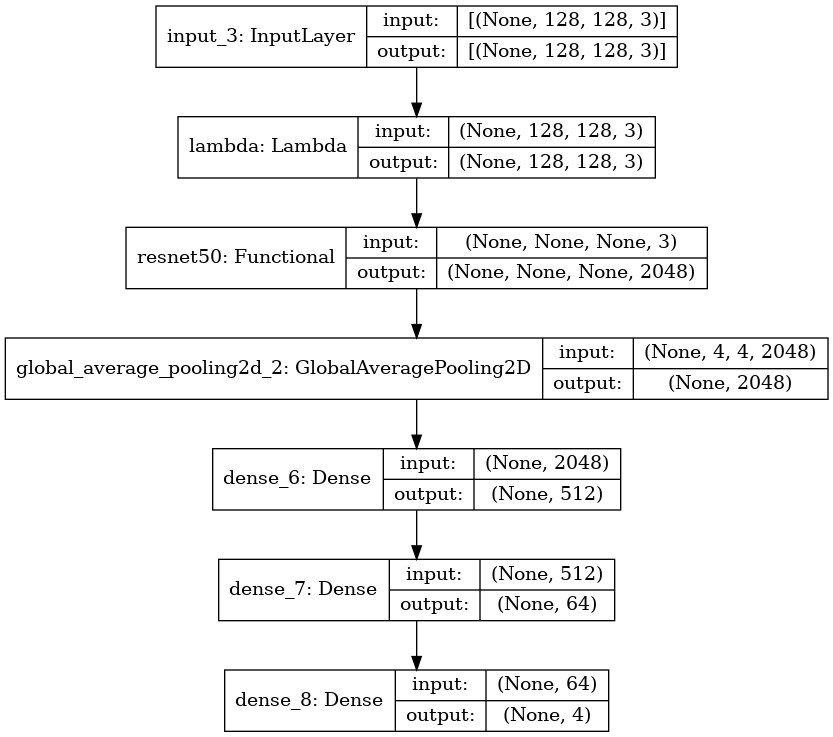

In [112]:
plot_model(resnet_model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)

In [118]:
resnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [119]:
history_resnet = resnet_model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
125/125 [==============================] - 26s 185ms/step - loss: 0.6136 - accuracy: 0.7447 - val_loss: 1.1814 - val_accuracy: 0.8337
Epoch 2/25
125/125 [==============================] - 21s 172ms/step - loss: 0.1943 - accuracy: 0.9311 - val_loss: 0.3233 - val_accuracy: 0.9211
Epoch 3/25
125/125 [==============================] - 21s 169ms/step - loss: 0.1107 - accuracy: 0.9615 - val_loss: 0.2944 - val_accuracy: 0.9146
Epoch 4/25
125/125 [==============================] - 22s 177ms/step - loss: 0.0784 - accuracy: 0.9738 - val_loss: 0.2090 - val_accuracy: 0.9342
Epoch 5/25
125/125 [==============================] - 22s 173ms/step - loss: 0.0512 - accuracy: 0.9824 - val_loss: 0.1454 - val_accuracy: 0.9563
Epoch 6/25
125/125 [==============================] - 21s 170ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.2117 - val_accuracy: 0.9352
Epoch 7/25
125/125 [==============================] - 22s 174ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.1100 - val_ac

**Plotting the model accuracy**

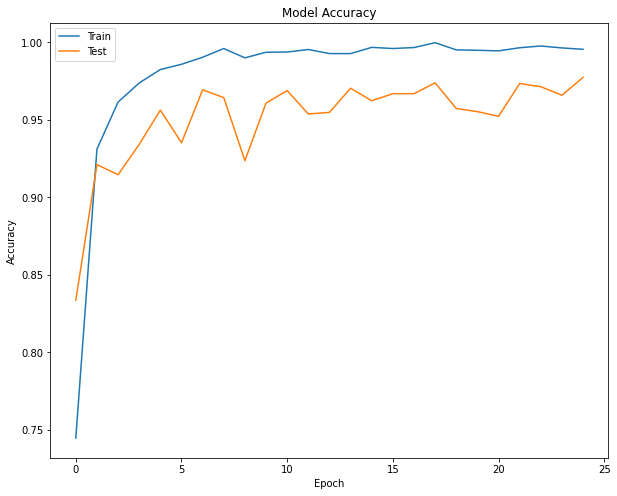

In [120]:
plt.figure(figsize=(10, 8))
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Plotting the model loss**

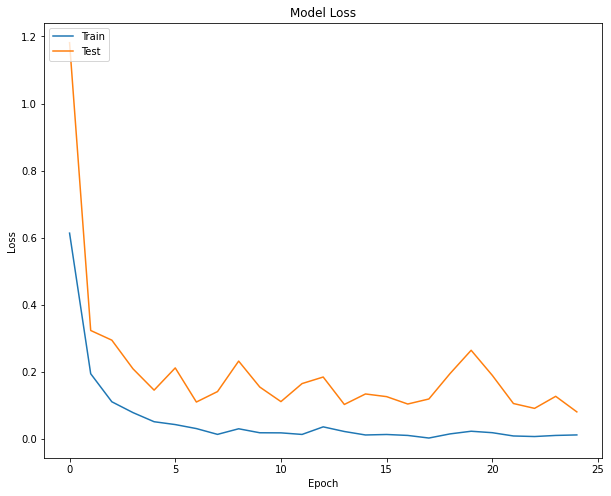

In [121]:
plt.figure(figsize=(10, 8))
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Saving model and training history**

In [122]:
cnn_model.save('ResNet_Model')

In [123]:
shutil.make_archive('resnet_model', 'zip', '/kaggle/working/ResNet_Model')

'/kaggle/working/resnet_model.zip'

In [124]:
hist_resnet_df = pd.DataFrame(history_resnet.history) 
with open('history_resnet.csv', mode='w') as f:
    hist_resnet_df.to_csv(f)

**Prediction on new images**

*Prediction on EOSINOPHIL Images*

In [125]:
eosinophil_val_df_res = predictNewImages(resnet_model, val_EOSINOPHIL)    
display(eosinophil_val_df_res)

,Image No.,Predicted WBC Type
0,1,EOSINOPHIL
1,2,EOSINOPHIL
2,3,EOSINOPHIL
3,4,EOSINOPHIL


*Prediction on LYMPHOCYTE Images*

In [126]:
lymphocyte_val_df_resnet = predictNewImages(resnet_model, val_LYMPHOCYTE)
display(lymphocyte_val_df_resnet)

,Image No.,Predicted WBC Type
0,1,LYMPHOCYTE
1,2,LYMPHOCYTE
2,3,LYMPHOCYTE
3,4,LYMPHOCYTE


*Prediction on MONOCYTE Images*

In [127]:
monocyte_val_df_resnet = predictNewImages(resnet_model, val_MONOCYTE)
display(monocyte_val_df_resnet)

,Image No.,Predicted WBC Type
0,1,MONOCYTE
1,2,MONOCYTE
2,3,EOSINOPHIL
3,4,EOSINOPHIL


*Prediction on NEUTROPHIL Images*

In [128]:
neutrophil_val_df_resnet = predictNewImages(resnet_model, val_NEUTROPHIL)
display(neutrophil_val_df_resnet)

,Image No.,Predicted WBC Type
0,1,NEUTROPHIL
1,2,NEUTROPHIL
2,3,NEUTROPHIL
3,4,NEUTROPHIL


***